# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [3]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - number of gameweeks required
FFP = 15

NEXT_GAMEWEEK = 19

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Getting data and choosing features

In [5]:
df = pd.read_csv('data/final_dataset.csv')

In [6]:
# remembering original df
df_original = df

In [7]:
# df.iloc[1]

In [8]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [9]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

C:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
df.shape

(7457, 13)

In [11]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking onyl players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [12]:
df.shape

(5771, 13)

In [13]:
df.head(20)

,Name,GW,FPL position,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Brenden-Aaronson,1,MID,83.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,Brenden-Aaronson,2,MID,90.0,0.0,2.0,0.0,0.1,0.1,0.1,0.0,0.0,2.0
2,Brenden-Aaronson,3,MID,82.0,1.0,2.0,2.0,1.0,1.0,0.1,1.0,1.0,8.0
3,Brenden-Aaronson,4,MID,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,Brenden-Aaronson,5,MID,75.0,0.0,1.0,1.0,0.1,0.1,0.1,0.0,1.0,5.0
5,Brenden-Aaronson,6,MID,90.0,0.0,1.0,0.0,0.0,0.0,0.3,0.0,0.0,2.0
6,Brenden-Aaronson,9,MID,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0
7,Brenden-Aaronson,10,MID,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0
8,Brenden-Aaronson,11,MID,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0
9,Brenden-Aaronson,12,MID,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0


In [14]:
last_names = df["Name"].unique()

In [15]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Sh', 'SoT', 'xG', 'npxG',
       'xAG', 'CS', 'Was Home', 'FPL'],
      dtype='object')

In [16]:
df["FPL position"].unique()

array(['MID', 'FWD', 'DEF', 'GK'], dtype=object)

# DF to DataLoader

In [17]:
# gk, def, mid, fwd
df_gk = df[df["FPL position"] == "GK"]
df_def = df[df["FPL position"] == "DEF"]
df_mid = df[df["FPL position"] == "MID"]
df_fwd = df[df["FPL position"] == "FWD"]

In [18]:
df.shape

(5771, 13)

In [19]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [20]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.index_table = init_index_table(dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        length = 0
        for name in self.names:
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [21]:
df[["Name", "FPL position"]].drop_duplicates().head(20)

,Name,FPL position
0,Brenden-Aaronson,MID
19,Che-Adams,FWD
39,Tyler-Adams,MID
56,Tosin-Adarabioyo,DEF
83,Rayan-Ait-Nouri,DEF
126,Nathan-Ake,DEF
143,Marc-Albrighton,MID
177,Trent-Alexander-Arnold,DEF
196,Alisson,GK
218,Miguel-Almiron,MID


In [22]:
dataset = PandasDataset(df)
dataset_gk = PandasDataset(df_gk)
dataset_def = PandasDataset(df_def)
dataset_mid = PandasDataset(df_mid)
dataset_fwd = PandasDataset(df_fwd)

In [23]:
dataset.__getitem__(0)

(array([[83. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.1,  0. ,  0. ],
        [82. ,  1. ,  2. ,  2. ,  1. ,  1. ,  0.1,  1. ,  1. ],
        [81. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [75. ,  0. ,  1. ,  1. ,  0.1,  0.1,  0.1,  0. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0.3,  0. ,  0. ],
        [78. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  1. ,  1. ],
        [75. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ]],
       dtype=float32),
 2.0)

In [24]:
dataset_mid.__getitem__(10)

(array([[90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.9,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.2,  0. ,  0. ],
        [85. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [82. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.1,  1. ,  0. ],
        [62. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0. ,  0. ,  1. ],
        [76. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.1,  0. ,  0. ]],
       dtype=float32),
 3.0)

In [25]:
dataset_gk.__len__()

305

In [26]:
dataset_def.__len__()

1137

In [27]:
dataset_mid.__len__()

1469

In [28]:
dataset_fwd.__len__()

356

In [29]:
batch_size = 16

In [30]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_gk = DataLoader(dataset_gk, batch_size=batch_size, shuffle=False)
dataloader_def = DataLoader(dataset_def, batch_size=batch_size, shuffle=False)
dataloader_mid = DataLoader(dataset_mid, batch_size=batch_size, shuffle=False)
dataloader_fwd = DataLoader(dataset_fwd, batch_size=batch_size, shuffle=False)

In [31]:
next(iter(dataloader_mid))

[tensor([[[83.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  1.0000],
          [90.0000,  0.0000,  2.0000,  ...,  0.1000,  0.0000,  0.0000],
          [82.0000,  1.0000,  2.0000,  ...,  0.1000,  1.0000,  1.0000],
          ...,
          [90.0000,  0.0000,  1.0000,  ...,  0.3000,  0.0000,  0.0000],
          [78.0000,  0.0000,  0.0000,  ...,  0.1000,  1.0000,  1.0000],
          [75.0000,  0.0000,  2.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[90.0000,  0.0000,  2.0000,  ...,  0.1000,  0.0000,  0.0000],
          [82.0000,  1.0000,  2.0000,  ...,  0.1000,  1.0000,  1.0000],
          [81.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [78.0000,  0.0000,  0.0000,  ...,  0.1000,  1.0000,  1.0000],
          [75.0000,  0.0000,  2.0000,  ...,  0.0000,  0.0000,  0.0000],
          [90.0000,  0.0000,  2.0000,  ...,  0.3000,  0.0000,  1.0000]],
 
         [[82.0000,  1.0000,  2.0000,  ...,  0.1000,  1.0000,  1.0000],
          [81.0000,  0.0000,

In [32]:
# next(iter(dataloader))[1]

# LSTM Model

In [33]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [34]:
len(dataloader)

205

In [35]:
# torch.transpose(next(iter(dataloader))[0], 0, 1).shape

In [36]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [37]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [38]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [39]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

In [40]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

# Training loop defined

In [41]:
criterion = nn.MSELoss()

In [42]:
def train_net(net, num_epochs, dataloader, optimizer):
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten()
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [43]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Training loop - general net

In [44]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 30, dataloader, optimizer)

Epoch 0 Loss: 3.920207099580183
Epoch 5 Loss: 3.695021712343867
Epoch 10 Loss: 3.677349189796099
Epoch 15 Loss: 3.5323258125200505
Epoch 20 Loss: 3.1140235324458376
Epoch 25 Loss: 3.0280237509710033
CPU times: total: 29min 52s
Wall time: 8min 59s


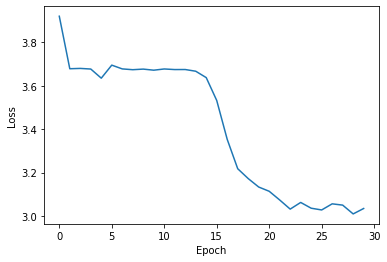

In [45]:
plot_loss_history(loss_history)

# Training loop - goalkeeper net

In [ ]:
%%time
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 50, dataloader_gk, optimizer_gk)

Epoch 0 Loss: 1.4823186468333005
Epoch 5 Loss: 0.5016054254025221
Epoch 10 Loss: 0.502277669031173
Epoch 15 Loss: 0.4998873141594231
Epoch 20 Loss: 0.5039562572725117
Epoch 25 Loss: 0.4997846018522978
Epoch 30 Loss: 0.5030941782519222
Epoch 35 Loss: 0.500559154804796


In [ ]:
plot_loss_history(loss_history_gk)

# Training loop - defender net

In [ ]:
%%time
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 50, dataloader_def, optimizer_def)

In [ ]:
plot_loss_history(loss_history_def)

# Training loop - midfielder net

In [ ]:
%%time
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 50, dataloader_mid, optimizer_mid)

In [ ]:
plot_loss_history(loss_history_mid)

# Training loop - forward net

In [ ]:
%%time
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.4)
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.005)
loss_history_fwd = train_net(net_fwd, 50, dataloader_fwd, optimizer_fwd)

In [ ]:
plot_loss_history(loss_history_fwd)

# Predictions

In [ ]:
index = 0
predictions = []
index_table = init_index_table(df) # index table for whole dataframe

for inputs, target in dataloader:
    inputs = torch.flatten(inputs, 1, 2)
    inputs = inputs.unsqueeze(2)
    # print("INPUTS", inputs)
    # print(inputs)
    outputs = net(inputs)
    # print("OUTPUTS", outputs)
    for output in outputs:
        player_id, sample_id = index_table[index]
        name = last_names[player_id]
        points = round(output.item(), 2)
        gw = sample_id + FIS + 1
        predictions.append([name, gw, points])
        # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
        index += 1

In [ ]:
# appending results to original df
for name, gw, points in predictions:
    df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [ ]:
df_original

In [ ]:
df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

In [ ]:
# results sorted
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)